In [1]:
import numpy as np
from scipy.stats import beta
from scipy.spatial import Voronoi
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, box, Point
from collections import defaultdict
from mpl_toolkits.mplot3d import Axes3D
import time
from shapely import contains_xy

In [2]:
def finite_polygons_2d(vor, radius=1e6, bbox=None):
    if bbox is None:
        bbox = [-0.1, -0.1, 1.1, 1.1]
    new_regions = []
    new_vertices = vor.vertices.tolist()
    all_ridges = defaultdict(list)

    for (p1, p2), (v1, v2) in zip(vor.ridge_points, vor.ridge_vertices):
        all_ridges[p1].append((p2, v1, v2))
        all_ridges[p2].append((p1, v1, v2))

    for p1, region_idx in enumerate(vor.point_region):
        region = vor.regions[region_idx]
        if -1 not in region:
            polygon = [vor.vertices[i] for i in region]
            new_regions.append(Polygon(polygon).buffer(0))
            continue

        ridges = all_ridges[p1]
        new_region = []
        for p2, v1, v2 in ridges:
            if v2 < 0:
                v1, v2 = v2, v1
            if v1 >= 0 and v2 >= 0:
                new_region.append(v2)
                continue
            tangent = vor.points[p2] - vor.points[p1]
            tangent /= np.linalg.norm(tangent)
            normal = np.array([-tangent[1], tangent[0]])
            midpoint = vor.points[[p1, p2]].mean(axis=0)
            far_point = vor.vertices[v2] + normal * radius
            new_vertices.append(far_point.tolist())
            new_region.append(v2)
            new_region.append(len(new_vertices) - 1)

        vs = np.array([new_vertices[v] for v in new_region])
        poly = Polygon(vs).buffer(0)
        poly = poly.intersection(box(*bbox))
        new_regions.append(poly)
    return new_regions

In [3]:
class PowerDiagram2D:
    def __init__(self, X, weights=None, L=1.0):
        self.X = np.array(X, copy=True)
        self.n = len(self.X)
        self.weights = np.zeros(self.n) if weights is None else np.array(weights, copy=True)
        self.L = L
        self.Cells = [None] * self.n
        self.indices = []
        self.updated_flag = False

    def update_laguerre_cells(self):
        vor = Voronoi(self.X)
        pad = 0.05 * self.L
        bbox = [-pad, -pad, self.L + pad, self.L + pad]
        polygons = finite_polygons_2d(vor, radius=1e3, bbox=bbox)
        self.Cells = [None] * self.n
        self.indices = []
        for i, poly in enumerate(polygons):
            if not poly.is_empty and poly.is_valid:
                self.Cells[i] = poly
                self.indices.append(i)
        self.updated_flag = True

    def compute_integrals(self, fun, grid_res=10):
        if not self.updated_flag:
            self.update_laguerre_cells()
    
        integrals = np.zeros(self.n)
        dx = self.L / grid_res
        area_per_cell = dx * dx
    
        xs = np.linspace(0, self.L, grid_res)
        ys = np.linspace(0, self.L, grid_res)
        Xg, Yg = np.meshgrid(xs, ys)
        grid_points = np.column_stack([Xg.ravel(), Yg.ravel()])  # (M^2, 2)
    
        domain = box(0, 0, self.L, self.L)
    
        for i in self.indices:
            cell = self.Cells[i].intersection(domain)
            if not cell.is_valid or cell.is_empty:
                continue
    
            # FAST vectorized check
            mask = contains_xy(cell, grid_points[:, 0], grid_points[:, 1])
            selected_pts = grid_points[mask]
            if selected_pts.size == 0:
                continue
    
            values = fun(selected_pts[:, 0], selected_pts[:, 1])
            integrals[i] = np.sum(values) * area_per_cell
    
        total = np.sum(integrals)
        if total > 0:
            integrals /= total  # optional normalization
        return integrals

    # def compute_integrals(self, fun):
    #     """
    #     Compute integrals over Laguerre cells assuming uniform density (Beta(1,1) × Beta(1,1)).
    #     This simply uses cell area as mass.
    #     """
    #     if not self.updated_flag:
    #         self.update_laguerre_cells()
    
    #     integrals = np.zeros(self.n)
    #     domain = box(0, 0, self.L, self.L)
    
    #     for i in self.indices:
    #         cell = self.Cells[i].intersection(domain)
    #         if not cell.is_valid or cell.is_empty:
    #             continue
    #         integrals[i] = cell.area  # uniform density -> mass = area (volume)
    
    #     total = np.sum(integrals)
    #     if total > 0:
    #         integrals /= total  # normalize to make it a probability vector
    #     return integrals

In [4]:
class OptimalTransport2D(PowerDiagram2D):
    def __init__(self, X, masses, rho, L=1.0):
        super().__init__(X, L=L)
        self.masses = np.array(masses, copy=True)
        self.rho = rho

    def compute_ot_cost(self, grid_res=10):
        if not self.updated_flag:
            self.update_laguerre_cells()
        integrals = np.zeros(self.n)
        dx = self.L / grid_res
        area_per_cell = dx * dx
        xs = np.linspace(0, self.L, grid_res)
        ys = np.linspace(0, self.L, grid_res)
        grid_points = np.array(np.meshgrid(xs, ys)).reshape(2, -1).T
        domain = box(0, 0, self.L, self.L)
        for i in self.indices:
            cell = self.Cells[i].intersection(domain)
            if not cell.is_valid or cell.is_empty:
                continue
            xi = self.X[i]
            mask = np.array([cell.contains(Point(pt)) for pt in grid_points])
            selected_pts = grid_points[mask]
            if selected_pts.size == 0:
                continue
            sq_dists = np.sum((selected_pts - xi)**2, axis=1)
            rho_vals = np.array([self.rho(x, y) for x, y in selected_pts])
            integrals[i] = np.sum((sq_dists - self.weights[i]) * rho_vals) * area_per_cell
        return np.sum(integrals) + np.sum(self.masses * self.weights)

    def update_weights(self, tol=1e-6, maxIter=50, verbose=False):
        alpha = 0.01
        tau_init = 0.5
        self.update_laguerre_cells()
        for it in range(maxIter):
            integrals = self.compute_integrals(self.rho)
            F = integrals - self.masses
            error = np.linalg.norm(F)
            if verbose:
                print(f"[{it}] Error: {error:.2e}")
            if error < tol:
                if verbose:
                    print("Converged!")
                break
            H = diags(np.ones(len(self.indices))).tocsc()
            try:
                dw_local = -spsolve(H, F[self.indices])
            except:
                dw_local = -F[self.indices]
            delta_w = np.zeros_like(self.weights)
            delta_w[self.indices] = dw_local * 0.5
            tau = tau_init
            cost_old = self.compute_ot_cost()
            for _ in range(10):
                new_weights = self.weights + tau * delta_w
                self.weights = new_weights
                self.update_laguerre_cells()
                try:
                    cost_new = self.compute_ot_cost()
                except:
                    cost_new = np.inf
                if np.isfinite(cost_new) and cost_new < cost_old:
                    break
                tau *= 0.5
            else:
                if verbose:
                    print("Line search failed.")
                break

In [17]:
# --- Parameters ---
N = 300               # Total number of samples
n_noise = 7           # Number of noise samples per corner
n_signal = N - 2 * n_noise
p = 1
np.random.seed(42)    # Reproducibility

# --- Signal from Beta(p,p) x Beta(p,p) ---
signal = np.column_stack((
    beta.rvs(p, p, size=n_signal),
    beta.rvs(p, p, size=n_signal)
))

# --- Noise cluster 1
noise1 = np.column_stack((
    beta.rvs(1, 50, size=n_noise),
    beta.rvs(1, 50, size=n_noise)
))

# --- Noise cluster 2
noise2 = np.column_stack((
    beta.rvs(50, 1, size=n_noise),
    beta.rvs(50, 1, size=n_noise)
))

# --- Combine and arrange ---
X_data = np.vstack([signal, noise1, noise2])
signal_idx = np.arange(n_signal)
noise1_idx = np.arange(n_signal, n_signal + n_noise)
noise2_idx = np.arange(n_signal + n_noise, N)

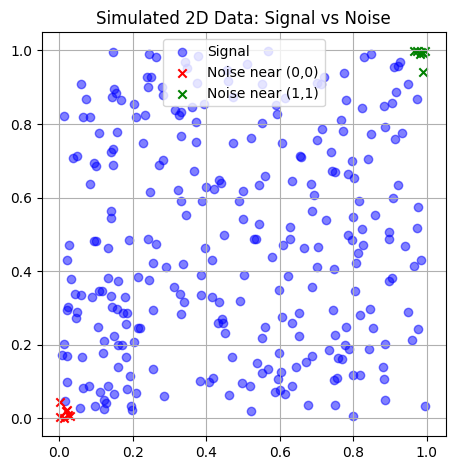

In [6]:
N = len(X_data)

# 1. Scatter plot of original 2D data
plt.scatter(X_data[signal_idx, 0], X_data[signal_idx, 1], color='blue', label='Signal', alpha=0.5)
plt.scatter(X_data[noise1_idx, 0], X_data[noise1_idx, 1], color='red', label='Noise near (0,0)', marker='x')
plt.scatter(X_data[noise2_idx, 0], X_data[noise2_idx, 1], color='green', label='Noise near (1,1)', marker='x')
plt.legend()
plt.grid(True)
plt.title("Simulated 2D Data: Signal vs Noise")
plt.axis('square')
plt.tight_layout()
plt.show()

In [7]:
L = 1.0
N = len(X_data)
masses = np.ones(N) / N

# Target distribution: Beta(1,1) x Beta(1,1)
rho = lambda x, y: 1.0

mass = 1.0
masses = masses * mass

eta = 1e-3
lam = 5
tol = 1e-20
maxiter = 3000

for i in range(maxiter):
    # Step 1: solve OT with current masses    
    start = time.time()
    ot = OptimalTransport2D(X_data, masses, rho, L=L)
    ot.update_weights(maxIter=1, verbose=False)
    print(f"Iteration {i}: weight update took {time.time() - start:.2f}s")

    ww = ot.weights

    # Step 2: update masses via fixed-point rule
    masses1 = masses + eta * (-1 - np.log(N * masses) - 2 * lam * ww)

    # Step 3: project back to simplex (same as 1D)
    temp = np.max(np.where((masses1 + 1 / (np.arange(1, N + 1)) * (1 - np.cumsum(masses1)) > 0))) + 1
    right_shift = (1 / temp) * (1 - np.cumsum(masses1)[temp - 1])
    masses1 = masses1 + right_shift
    masses1[masses1 < 0] = 0

    # Step 4: check convergence
    err = np.sum((masses - masses1) ** 2)
    if err <= tol:
        break

    # print(i)
    print(f"Error: {err}")
    masses = masses1

Iteration 0: weight update took 2.00s
Error: 2.6825463939720263e-07
Iteration 1: weight update took 2.00s
Error: 1.3019045338060889e-07
Iteration 2: weight update took 2.00s
Error: 6.368217054089683e-08
Iteration 3: weight update took 2.00s
Error: 3.131584218944028e-08
Iteration 4: weight update took 2.02s
Error: 1.545585385417605e-08
Iteration 5: weight update took 2.03s
Error: 7.647451942869296e-09
Iteration 6: weight update took 2.02s
Error: 3.790551342366146e-09
Iteration 7: weight update took 2.00s
Error: 1.881136696348476e-09
Iteration 8: weight update took 2.04s
Error: 9.343538097578586e-10
Iteration 9: weight update took 2.05s
Error: 4.643701422785164e-10
Iteration 10: weight update took 2.22s
Error: 2.3088800997023597e-10
Iteration 11: weight update took 2.15s
Error: 1.148333655271571e-10
Iteration 12: weight update took 2.07s
Error: 5.7124985055484246e-11
Iteration 13: weight update took 2.08s
Error: 2.842159434212553e-11
Iteration 14: weight update took 2.03s
Error: 1.414217

In [8]:
# check final error for comparison
print(f"Final error after loop: {err:.2e}")

Final error after loop: 5.71e-21


In [9]:
x = ot.weights

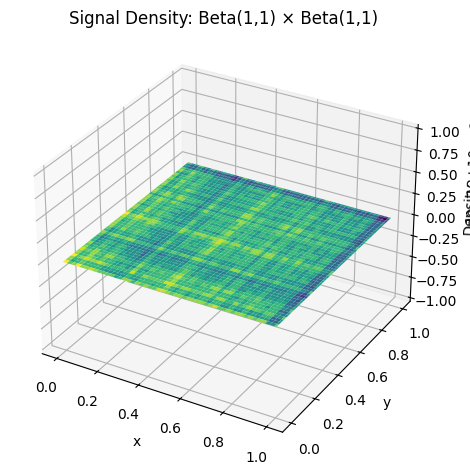

In [18]:
xs = np.linspace(0, 1, 100)
ys = np.linspace(0, 1, 100)
Xg, Yg = np.meshgrid(xs, ys)

# --- Joint density for Beta(p,p) × Beta(p,p) ---
Z = beta.pdf(Xg, p, p) * beta.pdf(Yg, p, p)

# --- Plotting ---
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.plot_surface(Xg, Yg, Z, cmap='viridis', edgecolor='none')
ax.set_title(f"Signal Density: Beta({p},{p}) × Beta({p},{p})")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("Density")
plt.tight_layout()
plt.show()

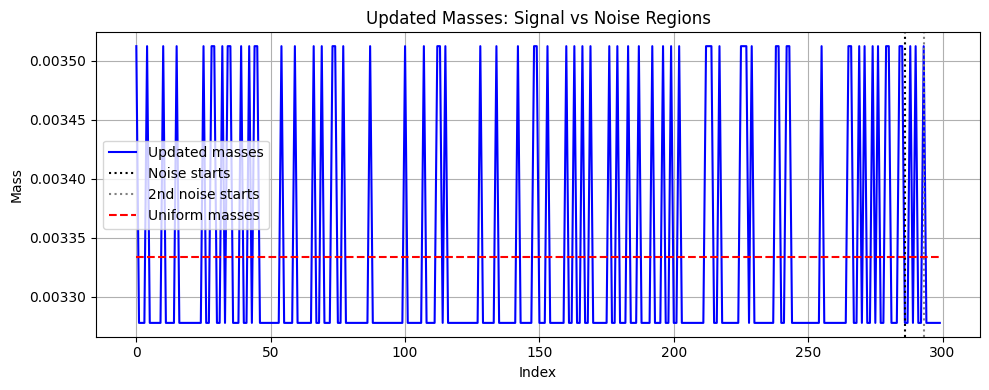

In [11]:
# Plot updated masses vs uniform masses
final_masses = masses

plt.figure(figsize=(10, 4))
plt.plot(final_masses, label='Updated masses', color='blue')
plt.axvline(noise1_idx[0], color='black', linestyle=':', label='Noise starts')
plt.axvline(noise2_idx[0], color='gray', linestyle=':', label='2nd noise starts')
plt.plot(np.ones(N) / N, color='red', linestyle='--', label='Uniform masses')
plt.legend()
plt.title("Updated Masses: Signal vs Noise Regions")
plt.xlabel("Index")
plt.ylabel("Mass")
plt.grid(True)
plt.tight_layout()
plt.show()

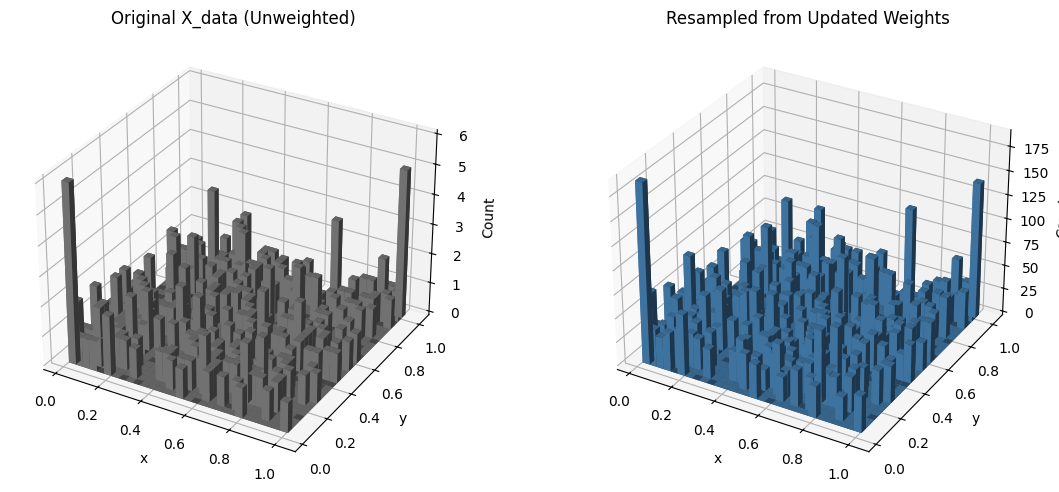

In [12]:
bins = 30

# --- Histogram for original X_data ---
H1, xedges, yedges = np.histogram2d(X_data[:, 0], X_data[:, 1], bins=bins, range=[[0, 1], [0, 1]])
xpos1, ypos1 = np.meshgrid(xedges[:-1] + 0.5*(xedges[1] - xedges[0]),
                           yedges[:-1] + 0.5*(yedges[1] - yedges[0]), indexing="ij")
xpos1 = xpos1.ravel()
ypos1 = ypos1.ravel()
zpos1 = np.zeros_like(xpos1)
dz1 = H1.ravel()

# --- Histogram for resampled points using final_masses ---
num_resample = 10000
resampled_points = X_data[np.random.choice(len(X_data), size=num_resample, p=final_masses)]
H2, _, _ = np.histogram2d(resampled_points[:, 0], resampled_points[:, 1], bins=[xedges, yedges])
xpos2, ypos2 = xpos1.copy(), ypos1.copy()
zpos2 = np.zeros_like(xpos2)
dz2 = H2.ravel()

# --- Plot side-by-side ---
fig = plt.figure(figsize=(12, 5))

# Original
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax1.bar3d(xpos1, ypos1, zpos1, dx=1/bins, dy=1/bins, dz=dz1, color='gray', zsort='average')
ax1.set_title("Original X_data (Unweighted)")
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax1.set_zlabel("Count")

# Resampled
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax2.bar3d(xpos2, ypos2, zpos2, dx=1/bins, dy=1/bins, dz=dz2, color='steelblue', zsort='average')
ax2.set_title("Resampled from Updated Weights")
ax2.set_xlabel("x")
ax2.set_ylabel("y")
ax2.set_zlabel("Count")

plt.tight_layout()
plt.show()